In [3]:
import json
import tarfile
import zipfile
import io
from PIL import Image
import torch
from collections import defaultdict

from PIL import Image
import torch
from open_clip import create_model_and_transforms, get_tokenizer
from open_clip.factory import _MODEL_CONFIGS
import matplotlib.pyplot as plt

In [4]:
# Load the model and config files
model_name = "cxrclip_local"

with open("custom-vit.json", "r") as f:
    config = json.load(f)
    model_cfg = config["model_cfg"]
    preprocess_cfg = config["preprocess_cfg"]

_MODEL_CONFIGS[model_name] = model_cfg
tokenizer = get_tokenizer(model_name)

In [6]:
model, _, preprocess = create_model_and_transforms(
    model_name=model_name,
    pretrained="epoch_50.pt",
    **{f"image_{k}": v for k, v in preprocess_cfg.items()},
)

# Process the tar file
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

In [ ]:
def load_image_text_pairs(file_path):
    """Load image-text pairs from tar or zip file without extraction"""
    image_text_pairs = defaultdict(list)
    
    # Determine file type and open appropriate archive
    if file_path.endswith('.tar'):
        archive = tarfile.open(file_path, 'r')
        get_members = lambda: archive.getmembers()
        get_name = lambda x: x.name
        is_file = lambda x: x.isfile()
        read_file = lambda x: archive.extractfile(x).read()
    elif file_path.endswith('.zip'):
        archive = zipfile.ZipFile(file_path, 'r')
        get_members = lambda: archive.filelist
        get_name = lambda x: x.filename
        is_file = lambda x: not x.filename.endswith('/')
        read_file = lambda x: archive.read(x)
    else:
        raise ValueError("Unsupported file format. Use .tar or .zip files")
    
    with archive:
        members = get_members()
        
        # Group image files with their corresponding text files
        for member in members:
            if is_file(member):
                base_name = get_name(member).rsplit('.', 1)[0]
                ext = get_name(member).split('.')[-1].lower()
                
                if ext in ['jpg', 'jpeg', 'png']:
                    image_text_pairs[base_name].append(('image', member))
                elif ext == 'txt':
                    image_text_pairs[base_name].append(('text', member))

        # Process valid pairs
        valid_pairs = []
        for base_name, files in image_text_pairs.items():
            if len(files) == 2:  # Only process if we have both image and text
                image_member = next(f[1] for f in files if f[0] == 'image')
                text_member = next(f[1] for f in files if f[0] == 'text')
                
                # Read image and resize to 224x224
                img_bytes = read_file(image_member)
                image = Image.open(io.BytesIO(img_bytes)).convert('RGB')
                image = image.resize((224, 224), Image.BICUBIC)
                
                # Read text
                text = read_file(text_member).decode('utf-8').strip()
                
                valid_pairs.append((image, text))
                
    return valid_pairs

image_text_pairs = load_image_text_pairs("mimic-test.tar")

In [ ]:
# def display_image_text_pairs(pairs, num_samples=3):
#     """Display a grid of image-text pairs with image sizes"""
#     num_samples = min(num_samples, len(pairs))
#     fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    
#     if num_samples == 1:
#         axes = [axes]
    
#     for idx, (ax, (image, text)) in enumerate(zip(axes, pairs[:num_samples])):
#         ax.imshow(image)
#         ax.axis('off')
#         # Truncate text if too long
#         display_text = text[:100] + '...' if len(text) > 100 else text
#         # Add image size to the title
#         size_text = f"Size: {image.size[0]}x{image.size[1]}"
#         ax.set_title(f"Sample {idx+1}\n{display_text}\n{size_text}", fontsize=8, wrap=True)
    
#     plt.tight_layout()
#     plt.show()

# # Display some sample pairs
# display_image_text_pairs(image_text_pairs)

In [1]:
from tqdm.auto import tqdm
import torch.nn.functional as F
import numpy as np


def get_clip_metrics(image_features, text_features, logit_scale):
    metrics = {}
    logits_per_image = (logit_scale * image_features @ text_features.t()).detach().cpu()
    logits_per_text = logits_per_image.t().detach().cpu()

    logits = {"image_to_text": logits_per_image, "text_to_image": logits_per_text}
    ground_truth = torch.arange(len(text_features)).view(-1, 1)

    for name, logit in logits.items():
        ranking = torch.argsort(logit, descending=True)
        preds = torch.where(ranking == ground_truth)[1]
        preds = preds.detach().cpu().numpy()
        metrics[f"{name}_mean_rank"] = preds.mean() + 1
        metrics[f"{name}_median_rank"] = np.floor(np.median(preds)) + 1
        for k in [1, 5, 10]:
            metrics[f"{name}_R@{k}"] = np.mean(preds < k)

    return metrics

def process_image_text_pairs(image_text_pairs, model, tokenizer, preprocess, device, batch_size=100):
    """
    Process image-text pairs in batches and extract features using CLIP model
    
    Args:
        image_text_pairs: List of (image, text) tuples
        model: CLIP model
        tokenizer: CLIP tokenizer
        preprocess: Image preprocessing function
        device: Device to run model on
        batch_size: Batch size for processing
        
    Returns:
        image_features: Tensor of image features
        text_features: Tensor of text features
        logit_scale: Model's logit scale
    """
    n_pairs = len(image_text_pairs)
    all_image_features = []
    all_text_features = []
    logit_scale = None

    # Process pairs in batches
    for i in tqdm(range(0, n_pairs, batch_size), desc="Processing batches"):
        batch_slice = slice(i, min(i + batch_size, n_pairs))
        current_batch = image_text_pairs[batch_slice]
        
        # Prepare batch inputs
        batch_images = [img for img, _ in current_batch]
        batch_texts = [text for _, text in current_batch]
        
        images = torch.stack([preprocess(img) for img in batch_images]).to(device)
        texts = tokenizer(batch_texts, context_length=512).to(device)
        
        with torch.no_grad():
            image_features, text_features, logit_scale = model(images, texts)
            all_image_features.append(image_features)
            all_text_features.append(text_features)
    
    return torch.cat(all_image_features), torch.cat(all_text_features), logit_scale

# Concatenate all features
image_features, text_features, logit_scale = process_image_text_pairs(
    image_text_pairs, model, tokenizer, preprocess, device, batch_size=100)

# Compute metrics on all data
metrics = get_clip_metrics(image_features, text_features, logit_scale)

# Print metrics
print("\nMetrics:")
for key, value in metrics.items():
    print(f"{key}: {value:.4f}")

Metrics:
image_to_text_mean_rank: 8.7
image_to_text_median_rank: 2.0
image_to_text_R@1: 0.4658
image_to_text_R@5: 0.7821
image_to_text_R@10: 0.8504
text_to_image_mean_rank: 7.8
text_to_image_median_rank: 2.0
text_to_image_R@1: 0.4872
text_to_image_R@5: 0.7564
text_to_image_R@10: 0.8547


Metrics:
image_to_text_mean_rank: 143.9
image_to_text_median_rank: 22.0
image_to_text_R@1: 0.0940
image_to_text_R@5: 0.2758
image_to_text_R@10: 0.3815
text_to_image_mean_rank: 141.4
text_to_image_median_rank: 21.0
text_to_image_R@1: 0.0942
text_to_image_R@5: 0.2694
text_to_image_R@10: 0.3778

In [9]:
!ls ../../writing/Figures/

# import numpy as np
# import cv2
# import matplotlib.pyplot as plt
# import random

clip-loss.png  global-crop-1.jpg  sample-x-ray.jpg
dino-loss.png  global-crop-2.jpg  vit_model_scheme.pdf


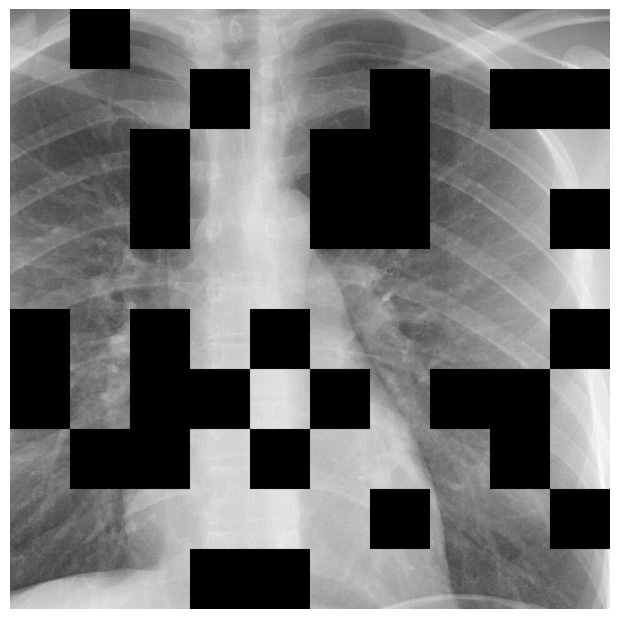

'../../writing/Figures/occluded-x-ray-1.jpg'

In [13]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random

# Load the image
image_path = "../../writing/Figures/global-crop-1.jpg"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load in grayscale

# Define patch size
patch_size = 96  # 32x32 pixel patches

# Get image dimensions
height, width = image.shape

# Ensure divisibility by patch size
new_height = (height // patch_size) * patch_size
new_width = (width // patch_size) * patch_size

# Crop image to be fully divisible by patch_size
image = image[:new_height, :new_width]

# Patchify the image
patches = [
    image[i:i+patch_size, j:j+patch_size]
    for i in range(0, new_height, patch_size)
    for j in range(0, new_width, patch_size)
]

# Randomly select 30% of patches to occlude
num_patches = len(patches)
num_occluded = int(0.3 * num_patches)
occluded_indices = random.sample(range(num_patches), num_occluded)

# Apply occlusion by replacing selected patches with black patches
for idx in occluded_indices:
    patches[idx] = np.zeros((patch_size, patch_size), dtype=np.uint8)

# Reconstruct the image
reconstructed = np.zeros_like(image)
patch_index = 0

for i in range(0, new_height, patch_size):
    for j in range(0, new_width, patch_size):
        reconstructed[i:i+patch_size, j:j+patch_size] = patches[patch_index]
        patch_index += 1

# Save and display the occluded image
occluded_image_path = "../../writing/Figures/occluded-x-ray-1.jpg"
cv2.imwrite(occluded_image_path, reconstructed)

# Display the occluded image
plt.figure(figsize=(6, 6))
plt.imshow(reconstructed, cmap="gray")
plt.axis("off")
plt.tight_layout(pad=0)  # Remove padding
plt.margins(0, 0)        # Remove margins
plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)  # Remove white space
plt.show()

# Provide output path
occluded_image_path
